# Import Modules 

In [35]:
from model.cnn import CNN
from model.unet import UNet
from utils.dataset import RXrayDataset, BXDataset, CXDataset
from utils.evaluate import * 
from torch.utils.data import DataLoader 
from torch.utils.data import random_split 
from tqdm import tqdm 
import torch
import torch.nn.functional as F 
import albumentations as A 
import imageio
import os
os.environ["CUDA_VISIBLE_DEVICES"] = "3"
import torch.nn as nn
from pytorch_msssim import ssim, ms_ssim, SSIM, MS_SSIM
import numpy as np
import math
import matplotlib.pyplot as plt
import cv2
import pydicom as di

from torchinfo import summary


# PSNR function

In [36]:
def PSNR(original, pred):
    mse = np.mean((original - pred) ** 2)
    if mse == 0:
        return 100
    PIXEL_MAX = 1.0
    PSNR = 20 * math.log10(PIXEL_MAX / math.sqrt(mse))
    return PSNR

def plot_images(images, cols=3):
#    plt.clf()
#    plt.figure(figsize(14,8))
    rows = math.ceil(images.shape[0]/cols)
    fig, ax = plt.subplots(nrows=rows, ncols=cols, figsize=(14,5*rows))

    idx = 0
    for row in ax:
        for col in row:
            if idx > images.shape[0]-1:
                break
            im = images[idx,:,:]
            col.imshow(im, cmap=plt.cm.bone)
            col.title.set_text(idx)
            idx += 1
    plt.show()

def standardize(img,m,s):
    
    if m==0 and s==0:
        m = img.mean()
        s = img.std()
    
    img = (img - m)/s
    
    return img, m, s

def unstandardize(img, m, s):
    
    img = img*s + m
    
    return img

# Parameter Set

# DATASET Defining

In [37]:

# test_xray_directory = 'data/Xray_real'
# test_xray_filenames = os.listdir(test_xray_directory)
# test_xray_filenames.remove('VIN_test')
# test_xray_filenames.remove('VIN_train')

# test_xray_directory = 'data/Xray_real/VIN_test'
# test_xray_filenames = os.listdir(test_xray_directory)

# image = di.dcmread(os.path.join(test_xray_directory, test_xray_filenames[3]))
# image = image.pixel_array
# plt.imshow(image, cmap=plt.cm.bone)

In [38]:
train_transforms = A.Compose(
    [
        A.Resize(width=512, height=512, p=1.0)
    ]
)

In [39]:
#image = cv2.cvtColor(image, cv2.COLOR_GRAY2RGB)
#image.max()
#plt.imshow(image, cmap=plt.cm.bone)

In [40]:
BATCH_SIZE_TEST = 1
model_iters = '17th'
test_xray_directory = 'data/Test/Xray' #real_4, nih, test, random
# test_xray_directory = 'data/Xray_real/test' #real_4, nih, test, random
test_xray_filenames = os.listdir(test_xray_directory)

# test_xray_directory = 'data/Xray_real/cropped_4'
# test_xray_filenames = os.listdir(test_xray_directory)

# dataset_test = BXDataset(test_xray_filenames,test_xray_directory,transform = train_transforms) #cropped_4, random
dataset_test = CXDataset(test_xray_filenames,test_xray_directory,transform = train_transforms) #nih
# dataset_test = RXrayDataset(test_xray_filenames,test_xray_directory,transform = train_transforms) #real_4, test

In [41]:
test_loader = DataLoader(dataset_test, BATCH_SIZE_TEST, shuffle = False)

# Model Creation

In [42]:
model = UNet()
critic = CNN()

# Training Phase

In [43]:
device = 'cuda' if torch.cuda.is_available() else 'cpu'
#device = 'cpu'
model= nn.DataParallel(model,device_ids = [0])
model  = torch.load('model_weights/'+model_iters+'/model1.ckpt')
critic= nn.DataParallel(critic,device_ids = [0])
critic  = torch.load('model_weights/'+model_iters+'/critic1.ckpt')

In [44]:
# from PIL import Image
# import os
# import numpy as np
# input_path = './data/n_Xray'
# xlist = os.listdir('./data/Xray')
# i = 0 
# for name in xlist:
    
#     path = os.path.join('./data/Xray', name)
    
#     images = np.load(path)
#     images = images.squeeze(0)
    
#     np.save(input_path+'/Xray_n_'+str(i),images)
#     print(i)
#     i=i+1

In [45]:
# from PIL import Image
# model.eval()
# pred = []
# xray = []
# input_path = './data/Xray'
# lungs_path = './data/Lungs'
# i = 0 
# for name in test_xray_filenames:
    
#     path = os.path.join(test_xray_directory, name)
    
#     images = process(path)
    
#     images = torch.from_numpy(images).unsqueeze(0)
    
#     images = images.to(device=device, dtype=torch.float32)
    
# #     images, _, _ = standardize(images,0,0)
#     with torch.no_grad():
#         mask_pred = model(images)
#         images = images.cpu().detach().numpy().squeeze(0).squeeze(0)
#         mask_pred = mask_pred.cpu().detach().numpy().squeeze(0).squeeze(0)
# #         mask_pred[mask_pred<0.03]=0

#         i = i + 1

#         images = process2(path)

# #         pred.append(mask_pred)
# #         xray.append(images)

#         np.save(input_path+'/Xray_'+str(i),images)
#         np.save(lungs_path+'/Lungs_'+str(i),mask_pred)
#         print(i)
#         if i ==2150:
#             break

In [46]:
model.eval()
preds = []
xray = []
# input_path = './data/Xray'
# lungs_path = './data/Lungs'
i = 0 
for batch, (images) in enumerate(test_loader):
    images = images.to(device=device, dtype=torch.float32)
#     images, _, _ = standardize(images,0,0)
    with torch.no_grad():
        mask_pred, _ = model(images)
        pred = critic(mask_pred)
        images = images.cpu().detach().numpy().squeeze(0).squeeze(0)
        mask_pred = mask_pred.cpu().detach().numpy().squeeze(0).squeeze(0)
        pred = pred.cpu().detach().numpy().squeeze(0).squeeze(0)
#         mask_pred = mask_pred[0][0].cpu().detach().numpy()
#         print(mask_pred.shape)
#         mask_pred[mask_pred<0.03]=0
        preds.append([mask_pred,pred])
        xray.append(images)
        i = i + 1
        if i==50:
            break
#         np.save('./data/P/Lungs_'+str(i),mask_pred)
        
#         print(f'Saved data: {i}')
#         break
#         np.save(input_path+'/Xray_'+str(i),images)

In [87]:
# plt.imshow(np.load('./data/P/Lungs_1.npy'), cmap=plt.cm.bone)

In [88]:
image = []
for x in range(len(preds)):
    im = xray[x]
#     im = np.transpose(im, (1, 2, 0))
#     print(im.shape)
#     break
#     im = cv2.cvtColor(im, cv2.COLOR_RGB2GRAY)
#     print(image.shape)
#     break
    image.append(im)
    image.append(preds[x][0])
    image.append(preds[x][1])


In [89]:
# plt.imshow(image[1], cmap=plt.cm.bone)
# image[0].shape

In [90]:
# lungs_path = './data/Lungs'
# L = os.listdir(lungs_path)
# idx = L[0][6:-4]
# idx = []
# for i in L:
#     idx.append(int(i[6:-4]))

In [91]:
# for i in range(1, 535):
#     if i not in idx:
#         print(i)

In [92]:
# input_path = './data/Xray'
# lungs_path = './data/Lungs'
# c = 1
# for i in range(0, len(image)):
#     if i % 2 == 0:
#         np.save(input_path+'/Xray_'+str(c),image[i].squeeze(2))
#     else:
#         np.save(lungs_path+'/Lungs_'+str(c),image[i])
#         c=c+1
    
# np.save(input_path+'/Luna16_Xray_'+str(i),CT_img2d)

In [93]:
# image = mask[62]
# plt.imshow(image, cmap=plt.cm.bone)

In [94]:
# lungs_path = './data/Lungs/Lungs_2.npy'

# # np.save(lungs_path,image)

# image = np.load(lungs_path)
# plt.imshow(image, cmap=plt.cm.bone)

In [95]:
# L[59]

# Erosion Dilation

In [96]:
# from skimage import io, morphology, measure
# import numpy as np

# lungs_path = './data/Lungs'
# new_path = './data/Mask'

# L = os.listdir(lungs_path)

# mask = []

# for x in range(0, len(L)):
    
#     temp_path = lungs_path + '/' + L[x]
#     image = np.load(temp_path)
#     save_path = new_path + '/' + L[x]
# #     mask.append(image)

#     img = (image > 0)*1

# #     plt.imshow(img, cmap=plt.cm.bone)
# #     plt.show()

#     kernel = np.ones((50, 50))

#     img = morphology.binary_erosion(img, footprint=kernel)
    
#     labeled_image = measure.label(img)

#     regions = measure.regionprops(labeled_image)
#     regions = sorted(regions, key=lambda region: region.area, reverse=True)

#     area_threshold = 40000

#     bw = np.zeros_like(image)
    
#     c=0
#     for region in regions:
#         area = region.area
#         label = region.label
#         if area >= area_threshold:
#             c=c+1
#             if c<=2:
#                 bw[labeled_image == label] = 1
#     img = bw

#     kernel = np.ones((50, 50))

#     img = morphology.binary_dilation(img, footprint=kernel)

#     image = image*img
    
# #     mask.append(image)

#     np.save(save_path,image)
    
#     print(x)
# #     if x ==100:
# #         break

# # plt.imshow(image, cmap=plt.cm.bone)
# # plt.show()

In [97]:
# img = mask[:100]

In [98]:
# plt.imshow(img, cmap=plt.cm.bone)
# plt.show()

In [99]:
# plt.hist(img[98].ravel(), bins=256, range=(0.1,1))
# plt.show()

In [100]:
# i = img[24]

In [101]:
# counts, bins, patches = plt.hist((i).ravel(), bins = 256, range=(.05,i.max()))
# total = sum(counts)

# c_mx = np.argmax(counts)

# # clipu = 0.99*total
# # clipl = 0.99*total
# # for x in range(len(counts)):
# #     if sum(counts[:x])>=clipu:
# #         break
# # u=x
# # image[image>bins[u+1]] = bins[u+1]
# bins[c_mx]

In [102]:
# b = bins[c_mx]
# if b<.8:
#     d = .8-b
# elif b>.9:
#     d = .9 -b
# else:
#     d=0

# i = i + d    

In [103]:
img=image[:99]

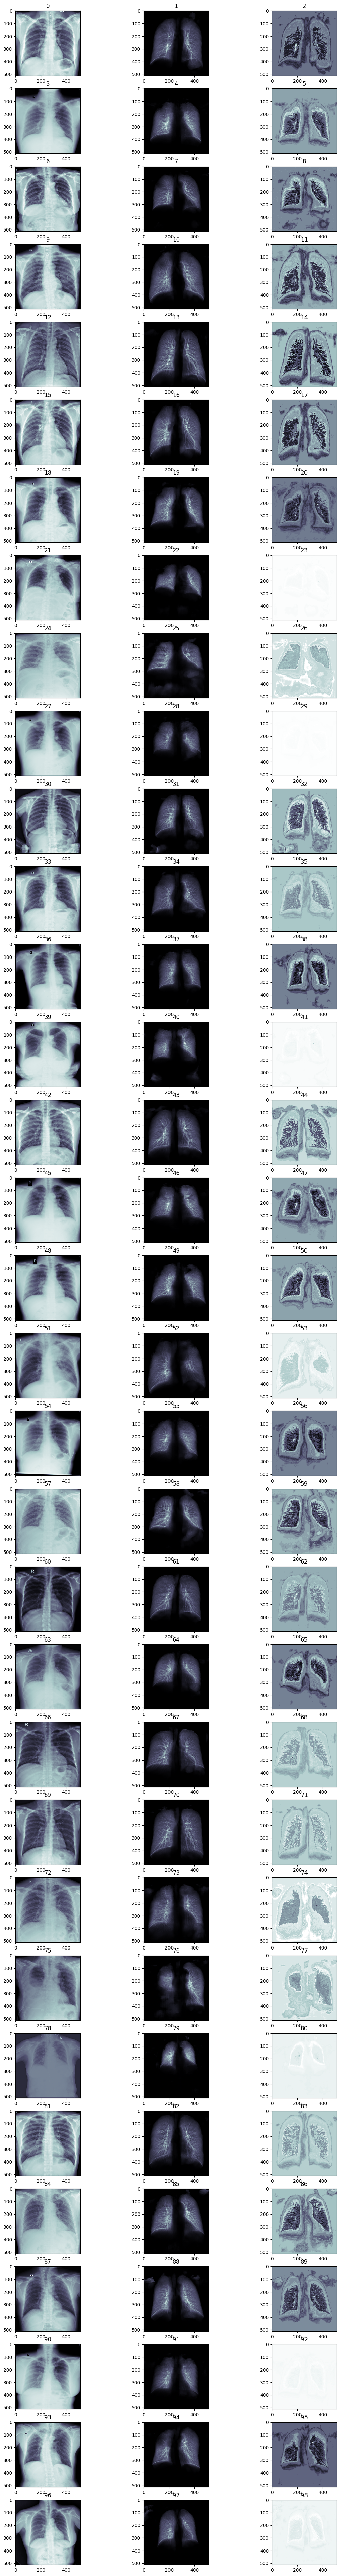

In [104]:
#plot_images(images, cols=3)
cols = 3
rows = math.ceil(len(img)/cols)
fig, ax = plt.subplots(nrows=rows, ncols=cols, figsize=(14,3*rows))

idx = 0
for row in ax:
    for col in row:
        if idx > len(img)-1:
            break 
        im = img[idx]
        col.imshow(im, cmap=plt.cm.bone)
        col.title.set_text(idx)
        idx += 1
plt.show()

In [105]:
# x = 1
# i = img[x]
# plt.imshow(i, cmap=plt.cm.bone)
# plt.xticks([])
# plt.yticks([])
# plt.savefig("images/l12.png", dpi=300, bbox_inches='tight')
# plt.show()

In [ ]:
# I = img[x+1]
# plt.imshow(I, cmap=plt.cm.bone)

In [12]:
# rpath = './data/GT/'
# gpath = './data/P/'
# real_path = os.listdir(rpath)
# gen_path = os.listdir(gpath)
# # real_path = [rpath+x for x in rfile]  # Add your image paths here
# # gen_path = [gpath+x for x in gfile]  # Add your image paths here
# real_path = random.sample(real_path, 772)

In [13]:
# len(real_path)

772

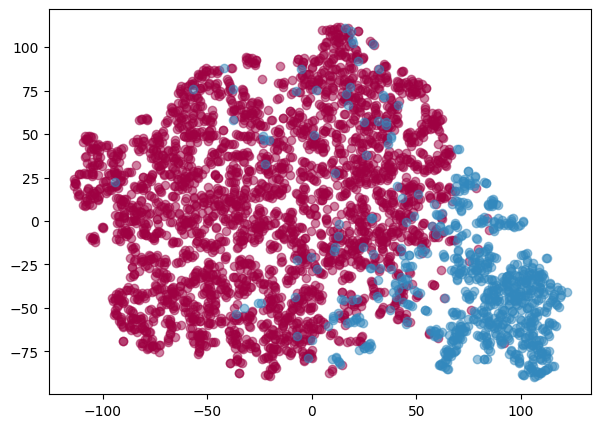

In [15]:
# import os
# import numpy as np
# import cv2
# import matplotlib.pyplot as plt
# from openTSNE import TSNE  # Use openTSNE instead of UMAP
# from sklearn.preprocessing import StandardScaler
# import random

# def standardize(img, m, s):
#     if s == 0:
#         s = img.std()
#     if m == 0:
#         m = img.mean()
#     img = (img - m) / s
#     return img, m, s

# # Function to load images from a directory
# def load_images_from_folder(path, idx, img_size=(256, 256)):
#     images = []
#     for filename in idx:
#         img = np.load(os.path.join(path, filename))
#         if img is not None:
# #             m = img.max()
# #             img = img / m
# #             img, mc, sc = standardize(img, 0, 0)
#             img = cv2.resize(img, img_size)  # Resize to fixed dimensions
#             images.append(img.flatten())  # Flatten the image into a vector
#     return np.array(images)

# # # Load dataset1 and dataset2
# # path = "data/Train/Xray"  # Replace with the actual path
# # xray_filenames = sorted(os.listdir(path))
# # l_id = 624 + 624 + 624 + 624 + 624 - 30
# # label_idx = random.sample(xray_filenames[:l_id], 1000)
# # unlabel_idx = random.sample(xray_filenames[l_id:], 1000)


# dataset1 = load_images_from_folder(gpath, gen_path) #data geneerated from real xray (red)
# dataset2 = load_images_from_folder(rpath, real_path) #simulated ground-truth lung xray label (blue)

# # dataset1 = load_images_from_folder(path, label_idx) #simulated x-ray (red)
# # dataset2 = load_images_from_folder(path, unlabel_idx) #real x-ray (blue)

# # Combine datasets and create labels
# combined_data = np.vstack((dataset1, dataset2))
# labels = np.array([0] * len(dataset1) + [1] * len(dataset2))  # 0 for dataset1, 1 for dataset2

# # # Standardize the data (important for openTSNE)
# scaler = StandardScaler()
# combined_data_scaled = scaler.fit_transform(combined_data)
# # combined_data_scaled = combined_data

# # Apply openTSNE
# tsne = TSNE(n_components=2, random_state=42, perplexity=10, n_iter=2000)
# tsne_results = tsne.fit(combined_data_scaled)

# # Visualize the results
# plt.figure(figsize=(7, 5))
# plt.scatter(
#     tsne_results[labels == 0, 0], tsne_results[labels == 0, 1],
#     c='#9e0142', label='Dataset1', alpha=0.5
# )
# plt.scatter(
#     tsne_results[labels == 1, 0], tsne_results[labels == 1, 1],
#     c='#3288bd', label='Dataset2', alpha=0.5
# )
# plt.savefig("images/tsne.svg", dpi=300, bbox_inches='tight')
# plt.show()

In [27]:
import os
import numpy as np
import cv2
import matplotlib.pyplot as plt
from openTSNE import TSNE  # Use openTSNE instead of UMAP
from sklearn.preprocessing import StandardScaler
import random
from openTSNE import TSNEEmbedding, affinity, initialization
from sklearn.manifold import TSNE
from sklearn.decomposition import PCA

def standardize(img, m, s):
    if s == 0:
        s = img.std()
    if m == 0:
        m = img.mean()
    img = (img - m) / s
    return img, m, s

# Function to load images from a directory
def load_images_from_folder(path, idx, img_size=(128, 128)):
    images = []
    for filename in idx:
        img = np.load(os.path.join(path, filename))
        if img is not None:
            m = img.max()
            img = img / m
            img, mc, sc = standardize(img, 0, 0)
            img = cv2.resize(img, img_size)  # Resize to fixed dimensions
            images.append(img)  # Flatten the image into a vector
    return np.array(images)


rpath = './data/GT/'
gpath = './data/P/'
real_path = os.listdir(rpath)
gen_path = os.listdir(gpath)
# real_path = [rpath+x for x in rfile]  # Add your image paths here
# gen_path = [gpath+x for x in gfile]  # Add your image paths here
# real_path = random.sample(real_path, 772)


# # # Load dataset1 and dataset2
# path = "data/Train/Xray"  # Replace with the actual path
# xray_filenames = sorted(os.listdir(path))
# l_id = 624 + 624 + 624 + 624 + 624 - 30
# label_idx = random.sample(xray_filenames[:l_id], 1000)
# unlabel_idx = random.sample(xray_filenames[l_id:], 1000)


dataset1 = load_images_from_folder(gpath, gen_path) #data geneerated from real xray (red)
dataset2 = load_images_from_folder(rpath, real_path) #simulated ground-truth lung xray label (blue)

# dataset1 = load_images_from_folder(path, label_idx) #simulated x-ray (red)
# dataset2 = load_images_from_folder(path, unlabel_idx) #real x-ray (blue)

# # Combine datasets and create labels
# combined_data = np.vstack((dataset1, dataset2))
# labels = np.array([0] * len(dataset1) + [1] * len(dataset2))  # 0 for dataset1, 1 for dataset2

# # # Standardize the data (important for openTSNE)
# scaler = StandardScaler()
# combined_data_scaled = scaler.fit_transform(combined_data)

# combined_data_scaled = combined_data

# # Apply openTSNE
# tsne = TSNE(n_components=2, random_state=42, perplexity=10, n_iter=2000)
# tsne_results = tsne.fit(combined_data_scaled)

# # Visualize the results
# plt.figure(figsize=(7, 5))
# plt.scatter(
#     tsne_results[labels == 0, 0], tsne_results[labels == 0, 1],
#     c='#9e0142', label='Dataset1', alpha=0.5
# )
# plt.scatter(
#     tsne_results[labels == 1, 0], tsne_results[labels == 1, 1],
#     c='#3288bd', label='Dataset2', alpha=0.5
# )
# plt.savefig("images/tsne.svg", dpi=300, bbox_inches='tight')
# plt.show()

# Stack datasets
x_train = np.vstack((dataset1, dataset2))
y_train = np.array([0] * len(dataset1) + [1] * len(dataset2))  # 0 for dataset1, 1 for dataset2


# Flatten images
x_train = x_train.reshape(len(x_train), -1)

# # # Standardize the data (important for openTSNE)
# scaler = StandardScaler()
# x_train = scaler.fit_transform(x_train)

# # Split into train and test sets
# x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.33, random_state=42)

# Compute affinities
affinities_train = affinity.PerplexityBasedNN(x_train, perplexity=10, metric="euclidean", n_jobs=8, random_state=42, verbose=True)

# Initialize embedding
init_train = initialization.pca(x_train, random_state=42)

# Construct t-SNE embedding
embedding_train = TSNEEmbedding(init_train, affinities_train, negative_gradient_method="fft", n_jobs=8, verbose=True)

# Optimize embedding (early exaggeration phase)
embedding_train_1 = embedding_train.optimize(n_iter=250, exaggeration=12)

# Optimize embedding (final)
embedding_train_2 = embedding_train_1.optimize(n_iter=1000)

===> Finding 30 nearest neighbors using Annoy approximate search using euclidean distance...
   --> Time elapsed: 38.61 seconds
===> Calculating affinity matrix...
   --> Time elapsed: 0.02 seconds
===> Running optimization with exaggeration=12.00, lr=314.33 for 250 iterations...
Iteration   50, KL divergence 4.7281, 50 iterations in 1.1316 sec
Iteration  100, KL divergence 4.8194, 50 iterations in 1.1733 sec
Iteration  150, KL divergence 4.8191, 50 iterations in 1.2040 sec
Iteration  200, KL divergence 4.8191, 50 iterations in 1.0997 sec
Iteration  250, KL divergence 4.8191, 50 iterations in 1.1557 sec
   --> Time elapsed: 5.77 seconds
===> Running optimization with exaggeration=1.00, lr=3772.00 for 1000 iterations...
Iteration   50, KL divergence 2.3244, 50 iterations in 1.1430 sec
Iteration  100, KL divergence 2.1157, 50 iterations in 1.8484 sec
Iteration  150, KL divergence 2.0262, 50 iterations in 2.6305 sec
Iteration  200, KL divergence 1.9758, 50 iterations in 3.6711 sec
Iterati

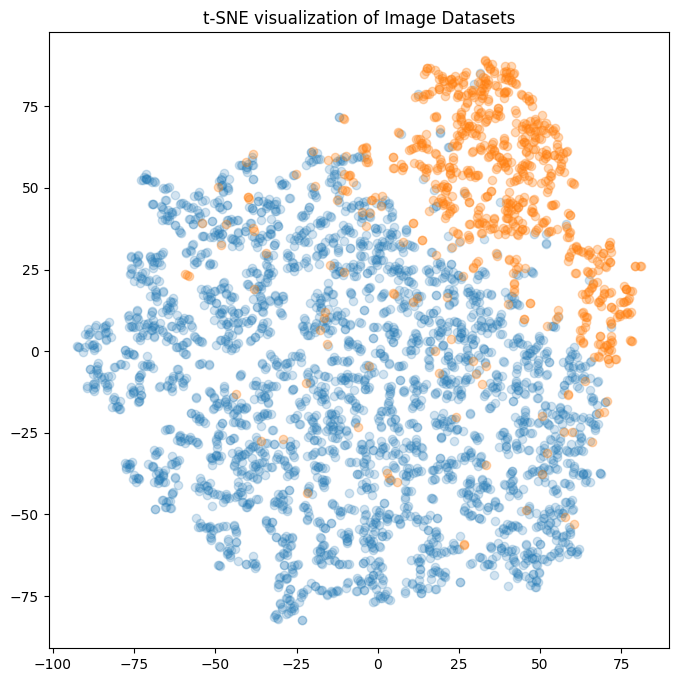

In [33]:
# Plot the embeddings
a = [0.2,0.3]
def plot_tsne(embedding, labels, title):
    plt.figure(figsize=(8, 8))
    unique_labels = np.unique(labels)
    c=0
    for label in unique_labels:
        indices = labels == label
        plt.scatter(embedding[indices, 0], embedding[indices, 1], label=label, alpha=a[c])
        c=c+1
    plt.title(title)
    plt.show()

plot_tsne(embedding_train_2, y_train, "t-SNE visualization of Image Datasets")

In [ ]:
# import torch
# import torchvision.transforms as transforms
# from torchvision import models
# from torch.utils.data import DataLoader
# from PIL import Image
# import numpy as np
# from scipy.stats import zscore

# # Define image transformations
# transform = transforms.Compose([
#     transforms.Resize((512, 512)),  # ResNet expects 224x224 images
#     transforms.ToTensor(),
#     transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
# ])

# # Load pre-trained InceptionV3 model
# inception_model = models.inception_v3(pretrained=True, transform_input=False)
# inception_model.fc = torch.nn.Identity()  # Remove the classification head
# inception_model.eval().to('cuda')
    
# def extract_features(image_path):
#     """Extract features from an image using the pre-trained model."""
#     image = np.load(image_path)
#     image = Image.fromarray(image).convert('RGB')
#     image = transform(image)
#     image = image.unsqueeze(0).to('cuda')
    
#     # Extract features
#     with torch.no_grad():
#         features = inception_model(image).cpu().numpy()
        
#     return features

# def calculate_fid(real_features, generated_features, device='cuda'):
# # Compute mean and covariance
#     mu_real, sigma_real = real_features.mean(axis=0), np.cov(real_features, rowvar=False)
#     mu_gen, sigma_gen = generated_features.mean(axis=0), np.cov(generated_features, rowvar=False)
    
#     # Calculate FID
#     diff = mu_real - mu_gen
#     covmean, _ = sqrtm(sigma_real @ sigma_gen, disp=False)
    
#     # Handle numerical instability
#     if not np.isfinite(covmean).all():
#         covmean = np.nan_to_num(covmean)
#     covmean = np.real(covmean)
    
#     fid = diff @ diff + np.trace(sigma_real + sigma_gen - 2 * covmean)
#     return fid


In [ ]:
# # Assume you have a list of image path
# rpath = './data/GT/'
# gpath = './data/P/'
# rfile = os.listdir(rpath)
# gfile = os.listdir(gpath)
# real_path = [rpath+x for x in rfile]  # Add your image paths here
# gen_path = [gpath+x for x in gfile]  # Add your image paths here
# # features = [extract_features(img_path) for img_path in image_paths]

In [ ]:
# gen_features = [extract_features(img) for img in gen_path]
# len(gen_features)

In [ ]:
# real_features = [extract_features(img) for img in real_path]
# len(real_features)

In [ ]:
# np.array(real_features).squeeze(1).shape

In [ ]:
# from scipy.linalg import sqrtm

# fid = calculate_fid(np.array(real_features).squeeze(1), np.array(gen_features).squeeze(1))

In [ ]:
# fid

In [2]:
# from torchmetrics.image.fid import FrechetInceptionDistance
# from torchmetrics.image.kid import KernelInceptionDistance
# from torchmetrics.image.inception import InceptionScore
# import os
# import numpy as np
# import torch
# from torch.utils.data import Dataset, DataLoader
# import torchvision.transforms as transforms
# from PIL import Image
# from tqdm import tqdm
# import random

# def standardize(img, m, s):
#     if s == 0:
#         s = img.std()
#     if m == 0:
#         m = img.mean()
#     img = (img - m) / s
#     return img, m, s


# # Load dataset1 and dataset2
# path = "data/Train/Xray"  # Replace with the actual path
# xray_filenames = sorted(os.listdir(path))
# l_id = 624 + 624 + 624 + 624 + 624 - 30
# label_idx = random.sample(xray_filenames[:l_id], 1000)
# unlabel_idx = random.sample(xray_filenames[l_id:], 1000)

# label = [os.path.join(path, f) for f in label_idx]
# unlabel = [os.path.join(path, f) for f in unlabel_idx]

# # Define a custom dataset for .npy files
# class NpyImageDataset(Dataset):
#     def __init__(self, label, transform=None):
#         self.file_paths = label
#         self.transform = transform

#     def __len__(self):
#         return len(self.file_paths)

#     def __getitem__(self, idx):
#         # Load the .npy file
#         img = np.load(self.file_paths[idx])  # Shape: (H, W), grayscale
#         m = img.max()
#         img = img / m
#         img, mc, sc = standardize(img, 0, 0)
#         img = Image.fromarray(img).convert('RGB')  # Scale [0,1] to [0,255] and convert to RGB
#         if self.transform:
#             img = self.transform(img)  # Apply transforms
#         return img

# # Define transformation pipeline
# transform = transforms.Compose([
#     transforms.Resize((512, 512)),  # Resize to 299x299 for Inception
#     transforms.ToTensor(),          # Convert to tensor with values [0, 1]
#     transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
# ])

# # Create datasets and data loaders
# real_dataset = NpyImageDataset(unlabel, transform=transform)
# generated_dataset = NpyImageDataset(label, transform=transform)

# real_loader = DataLoader(real_dataset, batch_size=1, shuffle=False)
# generated_loader = DataLoader(generated_dataset, batch_size=1, shuffle=False)

# # Initialize FID, KID, and IS metrics
# fid = FrechetInceptionDistance(feature=2048, normalize=True)
# kid = KernelInceptionDistance(subset_size=50, normalize=True)
# is_metric = InceptionScore(feature=2048, normalize=True)

# # Update metrics with real images
# for batch in tqdm(real_loader, desc="Processing Real Images"):
#     fid.update(batch, real=True)
#     kid.update(batch, real=True)

# # Update metrics with generated images
# for batch in tqdm(generated_loader, desc="Processing Real Images"):
#     fid.update(batch, real=False)
#     kid.update(batch, real=False)
#     is_metric.update(batch)

# # Compute FID, KID, and IS scores
# fid_score = fid.compute()
# kid_mean, kid_std = kid.compute()
# is_score, _ = is_metric.compute()

# print(f"FID score: {fid_score.item()}")
# print(f"KID mean: {kid_mean.item()}, KID std: {kid_std.item()}")
# print(f"Inception Score: {is_score.item()}")

/home/m-health/anaconda3/envs/pythonK/lib/python3.9/site-packages/torchmetrics/utilities/prints.py:43: UserWarning: Metric `Kernel Inception Distance` will save all extracted features in buffer. For large datasets this may lead to large memory footprint.
  warnings.warn(*args, **kwargs)  # noqa: B028
/home/m-health/anaconda3/envs/pythonK/lib/python3.9/site-packages/torchmetrics/utilities/prints.py:43: UserWarning: Metric `InceptionScore` will save all extracted features in buffer. For large datasets this may lead to large memory footprint.
  warnings.warn(*args, **kwargs)  # noqa: B028
Processing Real Images: 100%|███████████████████████████████████████| 1000/1000 [10:36<00:00,  1.57it/s]


FID score: 189.68788146972656
KID mean: 0.2093973159790039, KID std: 0.020947260782122612
Inception Score: 1.0559706687927246


In [4]:
# from torchmetrics.image.fid import FrechetInceptionDistance
# from torchmetrics.image.kid import KernelInceptionDistance
# from torchmetrics.image.inception import InceptionScore
# import os
# import numpy as np
# import torch
# from torch.utils.data import Dataset, DataLoader
# import torchvision.transforms as transforms
# from PIL import Image

# # Paths to real and generated image folders
# real_folder = "./data/GT/"
# generated_folder = "./data/P/"

# # Define a custom dataset for .npy files
# class NpyImageDataset(Dataset):
#     def __init__(self, folder_path, transform=None):
#         self.file_paths = [os.path.join(folder_path, f) for f in os.listdir(folder_path) if f.endswith('.npy')]
#         self.transform = transform

#     def __len__(self):
#         return len(self.file_paths)

#     def __getitem__(self, idx):
#         # Load the .npy file
#         img = np.load(self.file_paths[idx])  # Shape: (H, W), grayscale
#         img = Image.fromarray(img).convert('RGB')  # Scale [0,1] to [0,255] and convert to RGB
#         if self.transform:
#             img = self.transform(img)  # Apply transforms
#         return img


# # Define transformation pipeline
# transform = transforms.Compose([
#     transforms.Resize((512, 512)),  # Resize to 299x299 for Inception
#     transforms.ToTensor(),          # Convert to tensor with values [0, 1]
#     transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
# ])

# # Create datasets and data loaders
# real_dataset = NpyImageDataset(real_folder, transform=transform)
# generated_dataset = NpyImageDataset(generated_folder, transform=transform)

# real_loader = DataLoader(real_dataset, batch_size=1, shuffle=False)
# generated_loader = DataLoader(generated_dataset, batch_size=1, shuffle=False)

# # Initialize FID, KID, and IS metrics
# fid = FrechetInceptionDistance(feature=2048, normalize=True)
# kid = KernelInceptionDistance(subset_size=50, normalize=True)
# is_metric = InceptionScore(feature=2048, normalize=True)

# # Update metrics with real images
# for batch in tqdm(real_loader, desc="Processing Real Images"):
#     fid.update(batch, real=True)
#     kid.update(batch, real=True)

# # Update metrics with generated images
# for batch in tqdm(generated_loader, desc="Processing Real Images"):
#     fid.update(batch, real=False)
#     kid.update(batch, real=False)
#     is_metric.update(batch)

# # Compute FID, KID, and IS scores
# fid_score = fid.compute()
# kid_mean, kid_std = kid.compute()
# is_score, _ = is_metric.compute()

# print(f"FID score: {fid_score.item()}")
# print(f"KID mean: {kid_mean.item()}, KID std: {kid_std.item()}")
# print(f"Inception Score: {is_score.item()}")

Processing Real Images: 100%|███████████████████████████████████████| 3000/3000 [32:21<00:00,  1.55it/s]


FID score: 0.011240813881158829
KID mean: 1.4305114426349519e-08, KID std: 5.662127477989998e-08
Inception Score: 0.9999998807907104


In [ ]:
# # Convert features to a NumPy array
# features_array = np.array(features)

# # Step 3: Outlier Detection
# # Apply Z-score
# z_scores = np.abs(zscore(features_array, axis=0))
# z_thresh = 3  # Common threshold for identifying outliers
# outliers_z = np.where(z_scores > z_thresh)

# # Alternatively, apply IQR method
# Q1 = np.percentile(features_array, 25, axis=0)
# Q3 = np.percentile(features_array, 75, axis=0)
# IQR = Q3 - Q1
# outliers_iqr = np.where((features_array < (Q1 - 1.5 * IQR)) | (features_array > (Q3 + 1.5 * IQR)))

# # Find unique outlier indices
# outlier_indices_z = np.unique(outliers_z[0])
# outlier_indices_iqr = np.unique(outliers_iqr[0])

# # Remove outliers from the dataset
# filtered_image_paths_z = [path for i, path in enumerate(image_paths) if i in outlier_indices_z]
# filtered_image_paths_iqr = [path for i, path in enumerate(image_paths) if i in outlier_indices_iqr]

# print("Outliers identified by Z-score:", len(outlier_indices_z))
# print("Outliers identified by IQR:", len(outlier_indices_iqr))

In [ ]:
# image = []
# name = []
# for x in filtered_image_paths_z:
#     image.append(np.load(x))
#     name.append(x)

In [ ]:
# img = image
# len(img)

In [ ]:
# #plot_images(images, cols=3)
# cols = 3
# rows = math.ceil(len(img)/cols)
# fig, ax = plt.subplots(nrows=rows, ncols=cols, figsize=(14,3*rows))
# labels = ["Xray", "DrConf- Pred"]
# idx = 0
# for row in ax:
#     for col in row:
#         if idx > len(img)-1:
#             break 
#         im = img[idx]
#         col.imshow(im, cmap=plt.cm.bone)
#         col.title.set_text(idx)
#         col.set_xlabel(labels[idx%len(labels)])
#         idx += 1

In [ ]:
# import shutil
# import os

# def move_files(file_paths, destination_dir):
#     """
#     Move a list of files to a different directory.
    
#     Parameters:
#     file_paths (list): List of file paths to be moved.
#     destination_dir (str): The directory where files should be moved.
#     """
#     # Ensure the destination directory exists
#     os.makedirs(destination_dir, exist_ok=True)
    
#     for file_path in file_paths:
#         try:
#             # Extract the file name and create the destination path
#             file_name = os.path.basename(file_path)
#             dest_path = os.path.join(destination_dir, file_name)
#             # Move the file
#             shutil.move(file_path, dest_path)
#             print(f"Moved: {file_path} -> {dest_path}")
#         except FileNotFoundError:
#             print(f"File not found: {file_path}")
#         except PermissionError:
#             print(f"Permission denied: {file_path}")
#         except Exception as e:
#             print(f"Error moving {file_path}: {e}")

In [ ]:
# # Example usage
# path = './data/Test/Xray/Luna16_Xray_'
# file_paths = [path+x[31:] for x in filtered_image_paths_z]
# # file_paths = filtered_image_paths_z
# destination_dir = './data/Test/outliers/Xray/'
# move_files(file_paths, destination_dir)

In [ ]:
# filtered_image_paths_z[0][31:]

In [ ]:
# path = './data/Train/Xray/Luna16_Xray_'
# file_paths = [path+x[32:] for x in filtered_image_paths_z]

In [ ]:
# file_paths